In [70]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape, Dropout, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

import pandas as pd

In [71]:
df = pd.read_csv('AIerror_ONU16_15S_Cycle&Ai&Grantold.csv', usecols=[1], engine='python')
df.head()

,Ai
0,906
1,472
2,906
3,472
4,906


In [72]:
df = df.values
df = df.astype('float32')

In [73]:
df = df[:1000]
print(len(df))

1000


In [74]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [75]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

700 300


In [76]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [88]:
# reshape into X=t and Y=t+1
look_back = 10 #16
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [89]:
print(trainX.shape[0])
print(trainX.shape[1])

649
50


In [90]:
# reshape input to be [samples, time steps, features]
print(trainX.shape[1])
trainX = np.reshape(trainX, (trainX.shape[0], 2, 25))
testX = np.reshape(testX, (testX.shape[0], 2, 25))
#trainX = np.reshape(trainX, (trainX.shape[0], 1, 5)) #trainX.shape[1]
#testX = np.reshape(testX, (testX.shape[0], 1, 5))
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

50
(649, 2, 25)
(649,)
(249, 2, 25)
(249,)


In [79]:
# reshape input to be [samples, time steps, features]
print(trainX.shape[1])
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX = np.reshape(trainX, (trainX.shape[0], 10, 5)) #trainX.shape[1]
testX = np.reshape(testX, (testX.shape[0], 10, 5))
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

50
(649, 10, 5)
(649,)
(249, 10, 5)
(249,)


In [81]:
# create and fit the LSTM network
'''
model = Sequential()
#model.add(LSTM(40, input_shape=(1, look_back)))
model.add(LSTM(40, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1) #64 & 128
'''
#timesteps_ = look_back

inputs = Input(shape=(look_back,))
#inputs = LayerNormalization(axis=1)(inputs)
tgt1 = tf.keras.layers.Reshape((look_back,1),input_shape=(look_back,))(inputs)

tgt1 = LSTM(units=40,return_sequences = True, input_shape=(look_back,1))(tgt1)
tgt1 = Dropout(0.2)(tgt1)

tgt2 = LSTM(units=40,return_sequences = True)(tgt1)
tgt2 = Dropout(0.2)(tgt2)

tgt3 = LSTM(units=40,return_sequences = True)(tgt2)
tgt3 = Dropout(0.2)(tgt3)

tgt4 = LSTM(units=40)(tgt3)
tgt4 = Dropout(0.2)(tgt4)

predictions = Dense(1)(tgt4)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['mse','mae'])

history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_split=0.3) #[1,0,0], [0,0,1]

Epoch 1/100
8/8 [==============================] - 1s 139ms/step - loss: 0.0317 - mse: 0.0054 - mae: 0.0317 - val_loss: 0.0341 - val_mse: 0.0035 - val_mae: 0.0341
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0296 - mse: 0.0054 - mae: 0.0296 - val_loss: 0.0307 - val_mse: 0.0031 - val_mae: 0.0307
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0306 - mse: 0.0056 - mae: 0.0306 - val_loss: 0.0297 - val_mse: 0.0026 - val_mae: 0.0297
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0316 - mse: 0.0050 - mae: 0.0316 - val_loss: 0.0294 - val_mse: 0.0029 - val_mae: 0.0294
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0298 - mse: 0.0055 - mae: 0.0298 - val_loss: 0.0322 - val_mse: 0.0033 - val_mae: 0.0322
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0293 - mse: 0.0053 - mae: 0.0293 - val_loss: 0.0290 - val_mse: 0.0028 - val_mae: 0.0290
Epoch 7/100
8/8 [==========

8/8 [==============================] - 0s 11ms/step - loss: 0.0258 - mse: 0.0049 - mae: 0.0258 - val_loss: 0.0294 - val_mse: 0.0027 - val_mae: 0.0294
Epoch 98/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0262 - mse: 0.0049 - mae: 0.0262 - val_loss: 0.0295 - val_mse: 0.0028 - val_mae: 0.0295
Epoch 99/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0257 - mse: 0.0049 - mae: 0.0257 - val_loss: 0.0293 - val_mse: 0.0028 - val_mae: 0.0293
Epoch 100/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0256 - mse: 0.0049 - mae: 0.0256 - val_loss: 0.0294 - val_mse: 0.0028 - val_mae: 0.0294


look_back = 5, timesteps = 1, feature = 5

In [82]:
#batch_size = 64
from sklearn.metrics import mean_squared_error as mse
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mse(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mse(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# calculate root mean absolute error
trainScore2 = math.sqrt(mae(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMAE' % (trainScore2))
testScore2 = math.sqrt(mae(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMAE' % (testScore2))

Train Score: 22750.99 RMSE
Test Score: 26387.57 RMSE
Train Score: 96.19 RMAE
Test Score: 105.83 RMAE


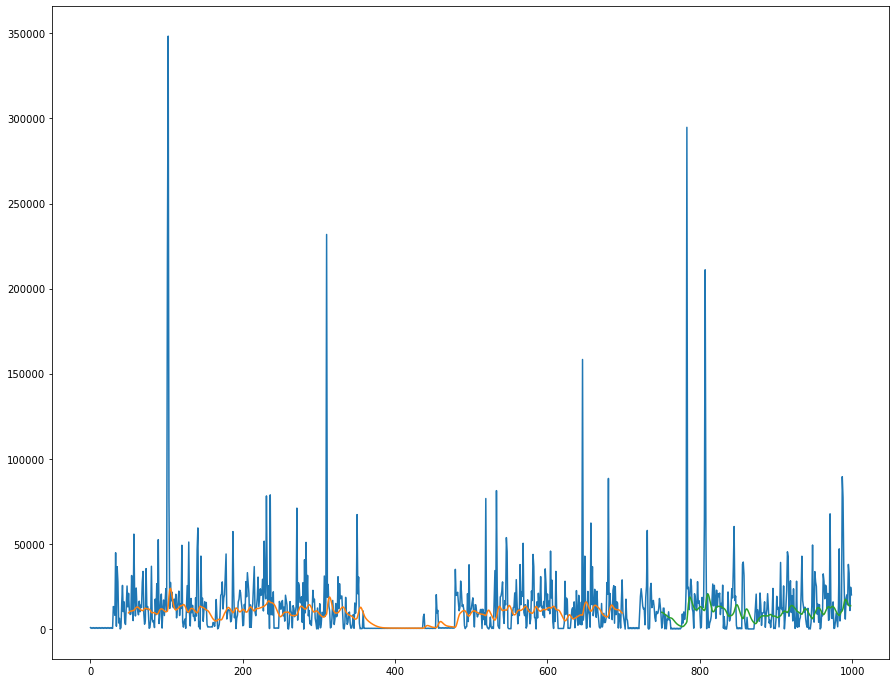

In [84]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 12))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [14]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 40)                6720      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


look_back = 5, timesteps = 5, feature = 1

In [12]:
#batch_size = 64
from sklearn.metrics import mean_squared_error as mse
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mse(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mse(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# calculate root mean absolute error
trainScore2 = math.sqrt(mae(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMAE' % (trainScore2))
testScore2 = math.sqrt(mae(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMAE' % (testScore2))

Train Score: 21104.14 RMSE
Test Score: 23779.90 RMSE
Train Score: 93.62 RMAE
Test Score: 99.04 RMAE


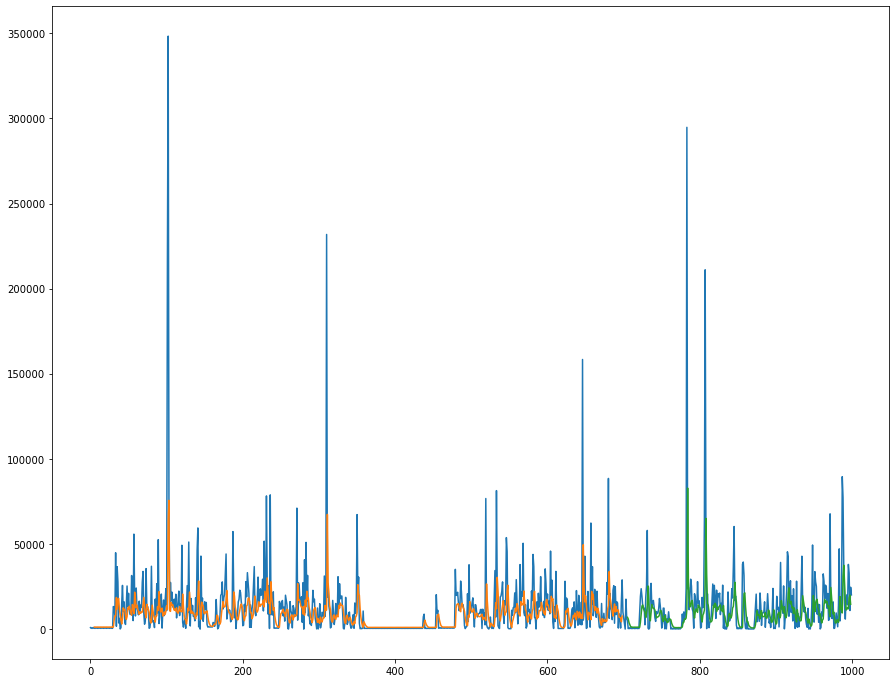

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 12))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [14]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 40)                6720      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________
